In [1]:
!pip install -q kneed
!pip install -q kneebow

  Preparing metadata (setup.py) ... done


In [2]:
import numpy as np
from datetime import datetime
import pandas as pd
import pprint
import os

In [3]:
folder_path = "/kaggle/input/stock-market-data-nifty-100-stocks-5-min-data"

# Dictionary to store mapping from original full path to cleaned stock name
csv_mapping = {}

# Iterate through files in the folder
for filename in os.listdir(folder_path):
    if filename.endswith(".csv"):
        full_path = os.path.join(folder_path, filename)
        
        # Clean the stock name by removing the '_with_indicators_' and '.csv'
        if filename.endswith("_with_indicators_.csv"):
            stock_name = filename.replace("_with_indicators_.csv", "")
        else:
            stock_name = filename.replace(".csv", "")
        
        csv_mapping[stock_name] = full_path


In [4]:
import warnings

warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from scipy.linalg import sqrtm
from itertools import combinations
from kneed import KneeLocator
from copy import deepcopy

# === Almgren-Chriss Class ===

class AlmgrenChriss:
    def __init__(self, params):
        self._lambda = params['lambda']
        self._H = params['H']
        self._tau = params['tau']
        self._epsilon = params['epsilon']
        self._C = params['C']

        # Ensure _C is 2D array
        if isinstance(self._C, (int, float, np.float64, np.float32)) or self._C.ndim == 0:
            self._C = np.array([[self._C]])

        self._m_stocks = self._C.shape[0]
        self._gamma = params['gamma']

        # Decompose symmetric/asymmetric parts
        self._gamma_s, self._gamma_a = self._decompose(self._gamma)
        self._H_s, self._H_a = self._decompose(self._H)

        # Symmetric effective H
        self._H_eff = self._H_s - self._gamma_s * self._tau / 2

        # === FIX: Ensure H_eff is symmetric and positive definite ===
        self._H_eff = 0.5 * (self._H_eff + self._H_eff.T)  # force symmetry
        eigvals = np.linalg.eigvalsh(self._H_eff)
        eps = (-np.min(eigvals)) + 1e-12
        # print("REGULARISATION: ", eps)
        self._H_eff += eps * np.eye(self._m_stocks)  # regularization

        # Check positive definiteness
        eigvals = np.linalg.eigvalsh(self._H_eff)
        if np.any(eigvals <= 0):
            print("H_eff: \n", self._H_eff)
            print("H_s: \n", self._H_s)
            print("gamma_s: \n", self._gamma_s)
            raise ValueError("H_eff is not positive definite after regularization.")

        # Compute matrix square roots and their inverses
        sqrt_H_eff = sqrtm(self._H_eff)
        if np.max(np.abs(sqrt_H_eff.imag)) < 1e-12:
            sqrt_H_eff = sqrt_H_eff.real
        else:
            raise ValueError("sqrt_H_eff has significant imaginary parts.")

        inv_sqrt_H_eff = np.linalg.inv(sqrt_H_eff)

        self._A = inv_sqrt_H_eff @ self._C @ inv_sqrt_H_eff
        self._B = inv_sqrt_H_eff @ self._gamma_a @ inv_sqrt_H_eff
        self._sqrt_H_eff = sqrt_H_eff
        self._inv_sqrt_H_eff = inv_sqrt_H_eff

    def _decompose(self, matrix):
        A_s = 0.5 * (matrix + matrix.T)
        A_a = 0.5 * (matrix - matrix.T)
        return A_s, A_a

    def trajectory(self, X_0, time):
        # self._lambda = self.find_optimal_lambda(X_0, time, np.logspace(-20, 0, 100))['lambda']
        N = int(time / self._tau)
        n = self._m_stocks
        sqrt_H_eff = self._sqrt_H_eff
        inv_sqrt_H_eff = self._inv_sqrt_H_eff

        system_size = n * (N + 1)
        SYSTEM = np.zeros((system_size, system_size))
        RHS = np.zeros(system_size)

        RHS[:n] = sqrt_H_eff @ X_0
        SYSTEM[:n, :n] = np.eye(n)

        coeff_prev = np.eye(n) - 0.5 * self._tau * self._B
        coeff_next = np.eye(n) + 0.5 * self._tau * self._B
        coeff_curr = 2 * np.eye(n) + self._lambda * self._tau ** 2 * self._A

        for t in range(1, N):
            row_start = t * n
            col_prev = (t - 1) * n
            col_curr = t * n
            col_next = (t + 1) * n

            SYSTEM[row_start:row_start + n, col_prev:col_prev + n] = -coeff_prev
            SYSTEM[row_start:row_start + n, col_curr:col_curr + n] = coeff_curr
            SYSTEM[row_start:row_start + n, col_next:col_next + n] = -coeff_next

        SYSTEM[-n:, -n:] = np.eye(n)

        Y_flat = np.linalg.solve(SYSTEM, RHS)
        Y = Y_flat.reshape((N + 1, n))
        X = (inv_sqrt_H_eff @ Y.T)
        return X

    def twap_trajectory(self, X0, T):
        """Return TWAP trajectory as an array of shape (n, T+1)."""
        n = len(X0)
        traj = np.zeros((n, T+1))
        for i in range(n):
            traj[i] = np.linspace(X0[i], 0, T+1)
        return traj

    def E_V_implementation_shortfall(self, X):
        X = X.T
        tau = self._tau
        N_plus1, m = X.shape
        N = N_plus1 - 1

        E_val = 0.0
        V_val = 0.0

        epsilon_term = np.sum(self._epsilon[:, np.newaxis] * np.abs(X.T))


        for k in range(1, N_plus1):
            xk = X[k]
            xk_prev = X[k - 1]
            vk = (xk_prev - xk) / tau

            E_val += tau * (xk.T @ self._gamma_s @ vk)
            E_val += tau * (vk.T @ (self._H_s - 0.5 * tau * self._gamma_s) @ vk)
            E_val += tau * (xk.T @ self._gamma_a @ vk)

            V_val += tau * (xk.T @ self._C @ xk)

        E_val += epsilon_term
        return E_val, V_val


    def print_lambda(self):
      print("Lambda: ", self._lambda)


In [5]:
def run_ac_analysis(tickers, X_0, start_date, end_date, ticker_path_map, lam=None, plot_overlay=False):

    # Results dictionary to be returned
    results = {}

    data_dict = {}
    for ticker in tickers:
        path = ticker_path_map[ticker]
        df = pd.read_csv(path, parse_dates=['date'])
        df = df.rename(columns={
            'date': 'Datetime',
            'open': f'Open_{ticker}',
            'high': f'High_{ticker}',
            'low': f'Low_{ticker}',
            'close': f'Close_{ticker}',
            'volume': f'Volume_{ticker}'
        })
        df = df[['Datetime', f'Open_{ticker}', f'High_{ticker}', f'Low_{ticker}', f'Close_{ticker}', f'Volume_{ticker}']]
        data_dict[ticker] = df

    df_merged = data_dict[tickers[0]]
    for t in tickers[1:]:
        df_merged = df_merged.merge(data_dict[t], on='Datetime')
    df_merged = df_merged.sort_values('Datetime').reset_index(drop=True)
    df_merged['DateOnly'] = df_merged['Datetime'].dt.date

    all_dates = sorted(df_merged['DateOnly'].unique())
    all_dates = [d for d in all_dates if start_date <= d <= end_date]

    if len(all_dates) < 2:
        raise ValueError("Need at least two dates in range for calibration and test.")

    for d_idx in range(1, len(all_dates)):
        calib_day = all_dates[d_idx - 1]
        test_day = all_dates[d_idx]

        df_calib = df_merged[df_merged['DateOnly'] == calib_day].reset_index(drop=True)
        df_test = df_merged[df_merged['DateOnly'] == test_day].reset_index(drop=True)

        print(f"\n=== Running for {test_day} (calibration on {calib_day}) ===")
        n = len(tickers)
        spread = np.array([(df_calib[f'High_{t}'] - df_calib[f'Low_{t}']).mean() for t in tickers])
        volume = np.array([df_calib[f'Volume_{t}'].mean() for t in tickers])
        C_data = np.vstack([
            np.diff(df_calib[f'Close_{t}'].values) for t in tickers
        ])
        C = np.cov(C_data)
        epsilon = spread / 2.0

        H = np.zeros((n, n))
        gamma = np.zeros((n, n))
        for i in range(n):
            for j in range(n):
                H[i, j] = spread[i] / (0.01 * volume[j])
                gamma[i, j] = (spread[i] / (0.1 * volume[j]) if i == j else spread[j] / (0.1 * volume[i]))

        best_lambda = lam
        if best_lambda is None:
            lambda_grid = np.logspace(-20, 20, 500)
            T_calib = len(df_calib)
            E_list, V_list = [], []
            for lam_trial in lambda_grid:
                params_try = {'lambda': lam_trial, 'C': C, 'epsilon': epsilon, 'H': H, 'gamma': gamma, 'tau': 1}
                model_try = AlmgrenChriss(params_try)
                traj_try = model_try.trajectory(X_0, T_calib)
                E, V = model_try.E_V_implementation_shortfall(traj_try)
                E_list.append(E)
                V_list.append(V)
            E_arr, V_arr = np.array(E_list), np.array(V_list)
            sorted_idx = np.argsort(V_arr)
            V_sorted, E_sorted = V_arr[sorted_idx], E_arr[sorted_idx]
            knee_locator = KneeLocator(V_sorted, E_sorted, curve='convex', direction='decreasing')
            elbow_v = knee_locator.knee
            if elbow_v is not None:
                elbow_index = np.argmin(np.abs(V_arr - elbow_v))
                best_lambda = lambda_grid[elbow_index]
            else:
                best_lambda = lambda_grid[np.argmin(np.sqrt(E_arr**2 + V_arr))]

        T = len(df_test)
        params = {'lambda': best_lambda, 'C': C, 'epsilon': epsilon, 'H': H, 'gamma': gamma, 'tau': 1}
        model = AlmgrenChriss(params)
        traj_ac = model.trajectory(X_0, T)
        traj_twap = model.twap_trajectory(X_0, T)

        volume_profile = np.array([df_calib[f'Volume_{t}'].values for t in tickers])
        volume_sums = volume_profile.sum(axis=1, keepdims=True)
        volume_weights = volume_profile / volume_sums
        T_calib = volume_profile.shape[1]
        if T < T_calib:
            volume_weights_test = volume_weights[:, :T]
        elif T > T_calib:
            pad_width = T - T_calib
            pad_values = np.tile(volume_weights[:, -1:], (1, pad_width))
            volume_weights_test = np.hstack([volume_weights, pad_values])
        else:
            volume_weights_test = volume_weights

        trades_per_minute = volume_weights_test * X_0[:, None]
        traj_vwap = np.zeros((n, T + 1))
        traj_vwap[:, 0] = X_0
        for t in range(T):
            traj_vwap[:, t + 1] = traj_vwap[:, t] - trades_per_minute[:, t]
        traj_vwap[:, -1] = 0

        S0 = np.array([df_test[f'Close_{t}'].iloc[0] for t in tickers])
        X0S0 = np.array(X_0) * S0
        E_ac, V_ac = model.E_V_implementation_shortfall(traj_ac)
        E_tw, V_tw = model.E_V_implementation_shortfall(traj_twap)
        E_vw, V_vw = model.E_V_implementation_shortfall(traj_vwap)
        net_slip_ac_bps = E_ac / np.sum(X0S0) * 1e4
        net_slip_tw_bps = E_tw / np.sum(X0S0) * 1e4
        net_slip_vw_bps = E_vw / np.sum(X0S0) * 1e4
        net_risk_ac_pct = np.sqrt(V_ac) / np.sum(X0S0) * 100
        net_risk_tw_pct = np.sqrt(V_tw) / np.sum(X0S0) * 100
        net_risk_vw_pct = np.sqrt(V_vw) / np.sum(X0S0) * 100

        S_t = np.array([[df_test[f'Close_{t}'].iloc[t_] for t in tickers] for t_ in range(T)])
        exec_price_path_ac = S_t * (np.diff(traj_ac, axis=1).T * -1)
        exec_price_path_twap = S_t * (np.diff(traj_twap, axis=1).T * -1)
        exec_price_path_vwap = S_t * (np.diff(traj_vwap, axis=1).T * -1)
        realized_slip_ac_bps = (np.sum(exec_price_path_ac) - np.sum(X0S0)) / np.sum(X0S0) * 1e4
        realized_slip_twap_bps = (np.sum(exec_price_path_twap) - np.sum(X0S0)) / np.sum(X0S0) * 1e4
        realized_slip_vwap_bps = (np.sum(exec_price_path_vwap) - np.sum(X0S0)) / np.sum(X0S0) * 1e4

        # results[test_day] = {
        #     'AC': {
        #         'expected_shortfall_bps': net_slip_ac_bps,
        #         'realized_shortfall_bps': realized_slip_ac_bps,
        #         'execution_risk_pct': net_risk_ac_pct
        #     },
        #     'TWAP': {
        #         'expected_shortfall_bps': net_slip_tw_bps,
        #         'realized_shortfall_bps': realized_slip_twap_bps,
        #         'execution_risk_pct': net_risk_tw_pct
        #     },
        #     'VWAP': {
        #         'expected_shortfall_bps': net_slip_vw_bps,
        #         'realized_shortfall_bps': realized_slip_vwap_bps,
        #         'execution_risk_pct': net_risk_vw_pct
        #     }
        # }

        # Execution values
        ac_exec_value = np.sum(exec_price_path_ac)
        twap_exec_value = np.sum(exec_price_path_twap)
        vwap_exec_value = np.sum(exec_price_path_vwap)
        vwap_exec_price_per_share = vwap_exec_value / np.sum(X_0)
        
        results[test_day] = {
            'AC': {
                'expected_shortfall_bps': net_slip_ac_bps,
                'realized_shortfall_bps': realized_slip_ac_bps,
                'execution_risk_pct': net_risk_ac_pct,
                'volume_weighted_price': ac_exec_value / np.sum(X_0),
                'slippage_vs_vwap_bps': (ac_exec_value - vwap_exec_value) / vwap_exec_value * 1e4
            },
            'TWAP': {
                'expected_shortfall_bps': net_slip_tw_bps,
                'realized_shortfall_bps': realized_slip_twap_bps,
                'execution_risk_pct': net_risk_tw_pct,
                'volume_weighted_price': twap_exec_value / np.sum(X_0),
                'slippage_vs_vwap_bps': (twap_exec_value - vwap_exec_value) / vwap_exec_value * 1e4
            },
            'VWAP': {
                'expected_shortfall_bps': net_slip_vw_bps,
                'realized_shortfall_bps': realized_slip_vwap_bps,
                'execution_risk_pct': net_risk_vw_pct,
                'volume_weighted_price': vwap_exec_price_per_share,
                'slippage_vs_vwap_bps': 0.0
            }
        }

        print("\n=== IS-based Slippage and Risk ===")
        print(f"Best lambda: {best_lambda}")
        print(f"AC Expected Shortfall:         {net_slip_ac_bps:.4f} bps")
        print(f"TWAP Expected Shortfall:       {net_slip_tw_bps:.4f} bps")
        print(f"VWAP Expected Shortfall:       {net_slip_vw_bps:.4f} bps")
        print(f"AC Realized Shortfall:         {realized_slip_ac_bps:.4f} bps")
        print(f"TWAP Realized Shortfall:       {realized_slip_twap_bps:.4f} bps")
        print(f"VWAP Realized Shortfall:       {realized_slip_vwap_bps:.4f} bps")
        print(f"AC Execution Risk:             {net_risk_ac_pct:.4f}%")
        print(f"TWAP Execution Risk:           {net_risk_tw_pct:.4f}%")
        print(f"VWAP Execution Risk:           {net_risk_vw_pct:.4f}%")

        print(f"AC Volume-Weighted Price:       {ac_exec_value / np.sum(X_0):.4f}")
        print(f"TWAP Volume-Weighted Price:     {twap_exec_value / np.sum(X_0):.4f}")
        print(f"VWAP Volume-Weighted Price:     {vwap_exec_value / np.sum(X_0):.4f}")
        print(f"AC Slippage vs VWAP:            {(ac_exec_value - vwap_exec_value) / vwap_exec_value * 1e4:.4f} bps")
        print(f"TWAP Slippage vs VWAP:          {(twap_exec_value - vwap_exec_value) / vwap_exec_value * 1e4:.4f} bps")
        print(f"VWAP Slippage vs VWAP:          {0.0000:.4f} bps")


        if plot_overlay:
            plt.figure(figsize=(14, 7))
            for i, t in enumerate(tickers):
                plt.plot(range(T + 1), traj_ac[i], label=f'AC {t}')
                plt.plot(range(T + 1), traj_twap[i], '--', label=f'TWAP {t}')
                plt.plot(range(T + 1), traj_vwap[i], ':', label=f'VWAP {t}')
            plt.title(f"Execution Trajectories on {test_day}")
            plt.xlabel('Time Step (5 min)')
            plt.ylabel('Shares Remaining')
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            plt.show()
            for ticker in tickers:
                close_prices = df_test[f'Close_{ticker}'].values
                volume_data = df_test[f'Volume_{ticker}'].values
                time_stamps = df_test['Datetime']
        
                avg_min_vol = volume_data.mean()
                total_vol = volume_data.sum()
        
                fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5), gridspec_kw={'width_ratios': [3, 1]})
                
                ax1.plot(time_stamps, close_prices, color='blue', label='Close Price')
                ax1.set_title(f'{ticker} Price on {test_day}')
                ax1.set_xlabel('Time')
                ax1.set_ylabel('Price')
                ax1.grid(True)
                ax1.tick_params(axis='x', rotation=45)
        
                ax2.plot(time_stamps, volume_data, color='orange', label='Volume')
                ax2.set_title(f'{ticker} Volume on {test_day}')
                ax2.set_xlabel('Time')
                ax2.set_ylabel('Volume')
                ax2.grid(True)
                ax2.tick_params(axis='x', rotation=45)
        
                text_str = f"Avg/Min Vol: {avg_min_vol:,.0f}\nTotal Vol: {total_vol:,.0f}"
                ax2.text(0.95, 0.95, text_str, ha='right', va='top', transform=ax2.transAxes,
                         bbox=dict(facecolor='white', alpha=0.8))
        
                plt.suptitle(f"{ticker} Intraday Price & Volume - {test_day}", fontsize=14)
                plt.tight_layout(rect=[0, 0, 1, 0.95])
                plt.show()

    return results



=== Running for 2020-03-03 (calibration on 2020-03-02) ===

=== IS-based Slippage and Risk ===
Best lambda: 8.547984528840422e-15
AC Expected Shortfall:         220.9230 bps
TWAP Expected Shortfall:       666.8856 bps
VWAP Expected Shortfall:       689.6471 bps
AC Realized Shortfall:         1.8531 bps
TWAP Realized Shortfall:       -59.9582 bps
VWAP Realized Shortfall:       -39.0811 bps
AC Execution Risk:             0.2615%
TWAP Execution Risk:           1.1075%
VWAP Execution Risk:           1.0670%
AC Volume-Weighted Price:       1332.3969
TWAP Volume-Weighted Price:     1324.1627
VWAP Volume-Weighted Price:     1326.9438
AC Slippage vs VWAP:            41.0948 bps
TWAP Slippage vs VWAP:          -20.9590 bps
VWAP Slippage vs VWAP:          0.0000 bps


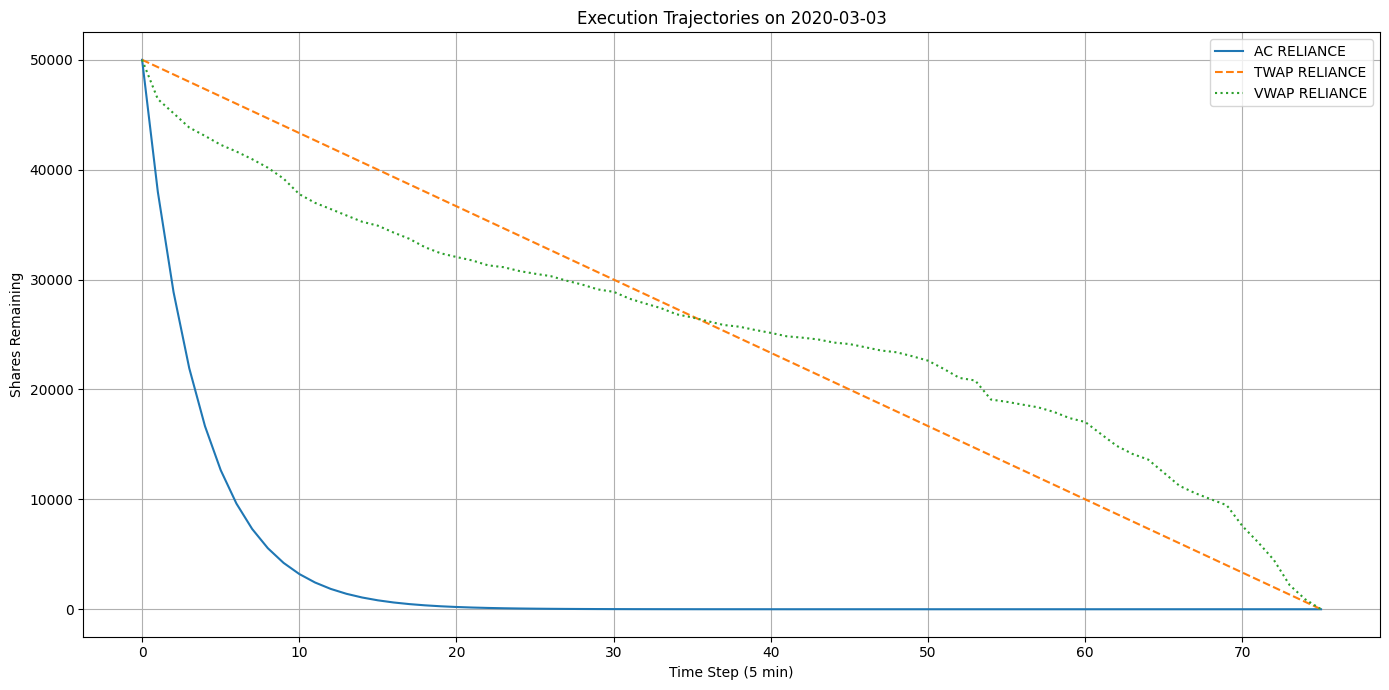

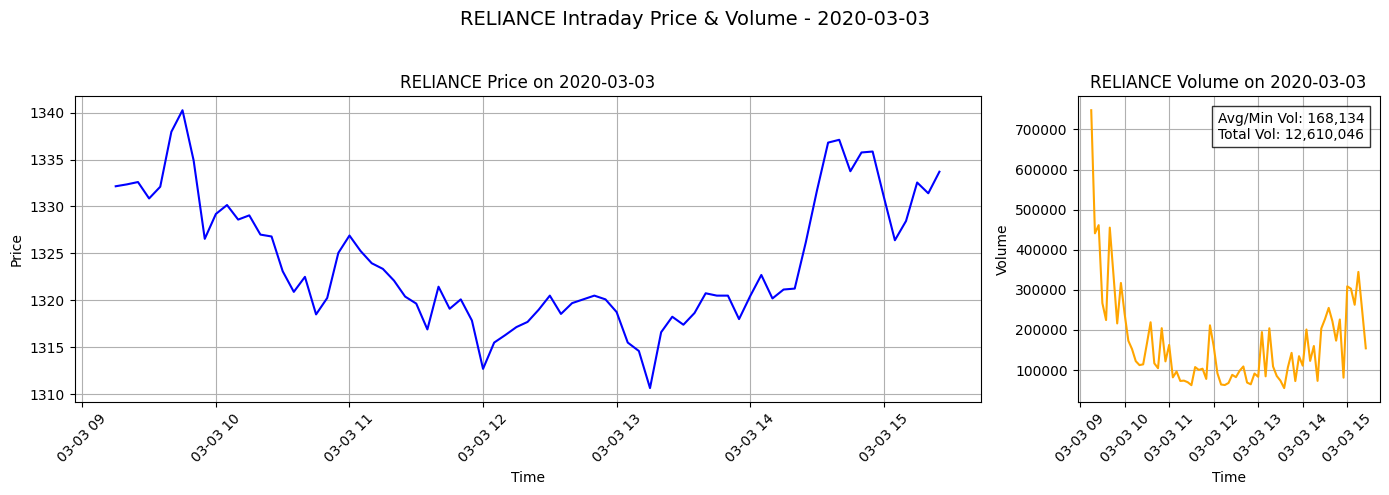


=== Running for 2020-03-04 (calibration on 2020-03-03) ===

=== IS-based Slippage and Risk ===
Best lambda: 8.547984528840422e-15
AC Expected Shortfall:         252.4619 bps
TWAP Expected Shortfall:       737.2858 bps
VWAP Expected Shortfall:       682.0094 bps
AC Realized Shortfall:         -8.6543 bps
TWAP Realized Shortfall:       -80.8145 bps
VWAP Realized Shortfall:       -65.5565 bps
AC Execution Risk:             0.2573%
TWAP Execution Risk:           1.0547%
VWAP Execution Risk:           0.9222%
AC Volume-Weighted Price:       1328.1496
TWAP Volume-Weighted Price:     1318.5573
VWAP Volume-Weighted Price:     1320.5856
AC Slippage vs VWAP:            57.2776 bps
TWAP Slippage vs VWAP:          -15.3587 bps
VWAP Slippage vs VWAP:          0.0000 bps


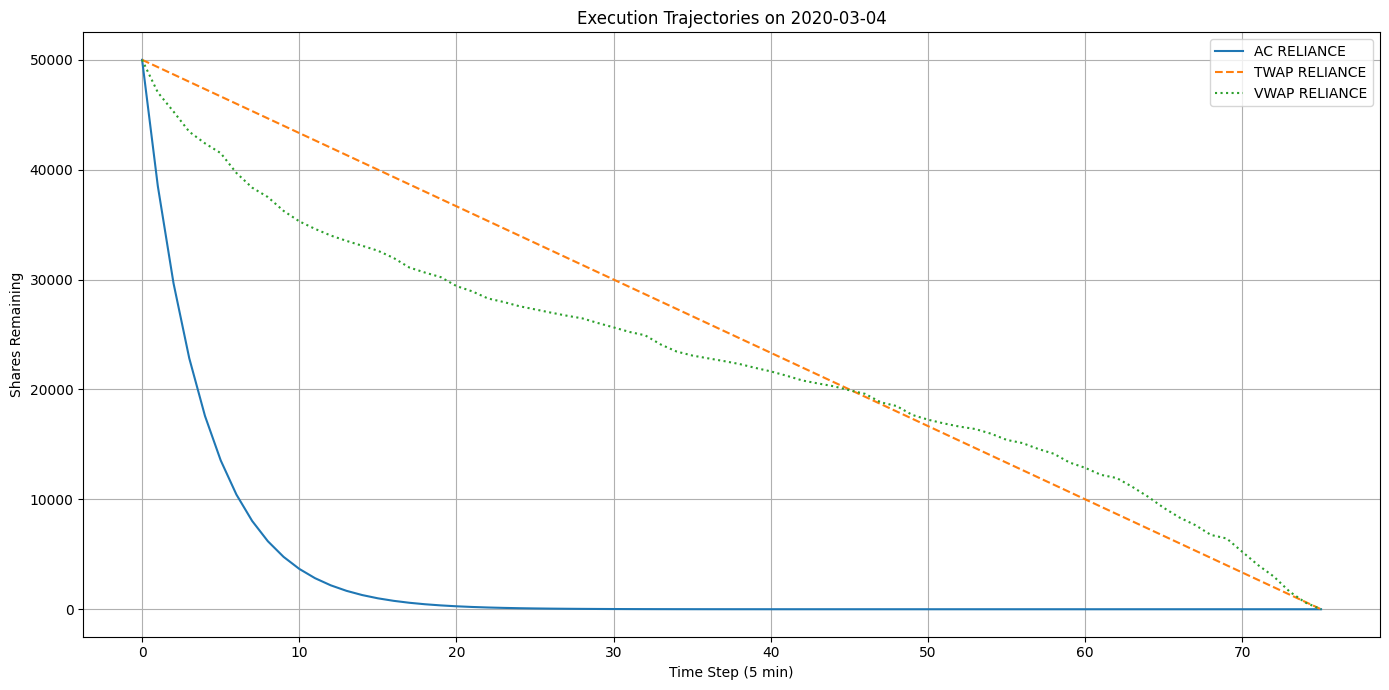

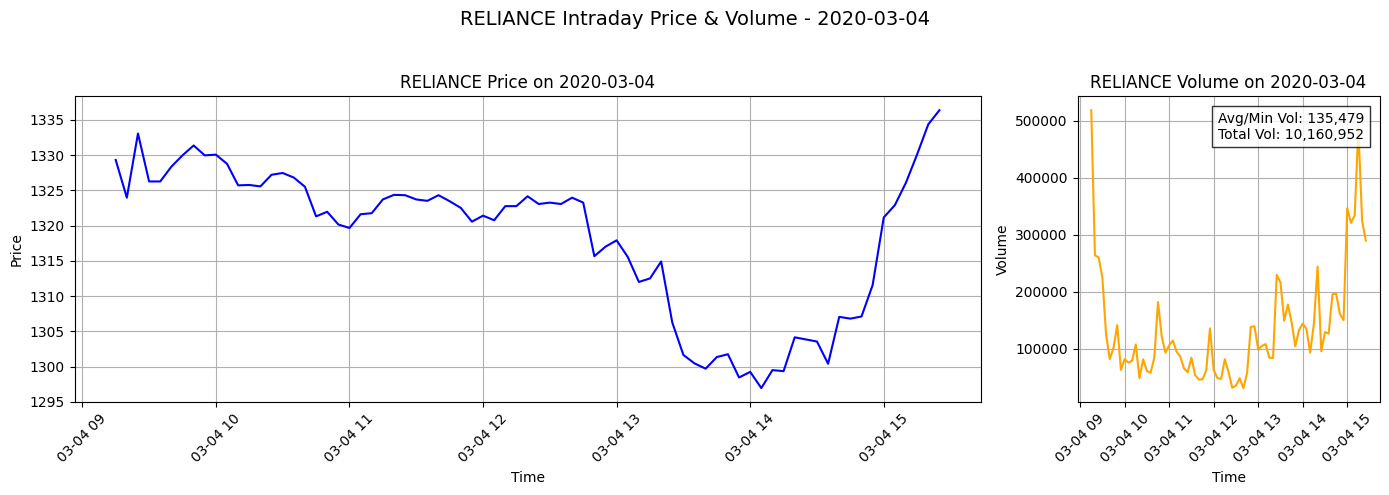


=== Running for 2020-03-05 (calibration on 2020-03-04) ===

=== IS-based Slippage and Risk ===
Best lambda: 7.107279696773412e-15
AC Expected Shortfall:         242.0102 bps
TWAP Expected Shortfall:       621.3548 bps
VWAP Expected Shortfall:       697.5981 bps
AC Realized Shortfall:         -43.4362 bps
TWAP Realized Shortfall:       -102.7733 bps
VWAP Realized Shortfall:       -123.9475 bps
AC Execution Risk:             0.2799%
TWAP Execution Risk:           1.1342%
VWAP Execution Risk:           1.1965%
AC Volume-Weighted Price:       1325.3680
TWAP Volume-Weighted Price:     1317.4693
VWAP Volume-Weighted Price:     1314.6507
AC Slippage vs VWAP:            81.5217 bps
TWAP Slippage vs VWAP:          21.4400 bps
VWAP Slippage vs VWAP:          0.0000 bps


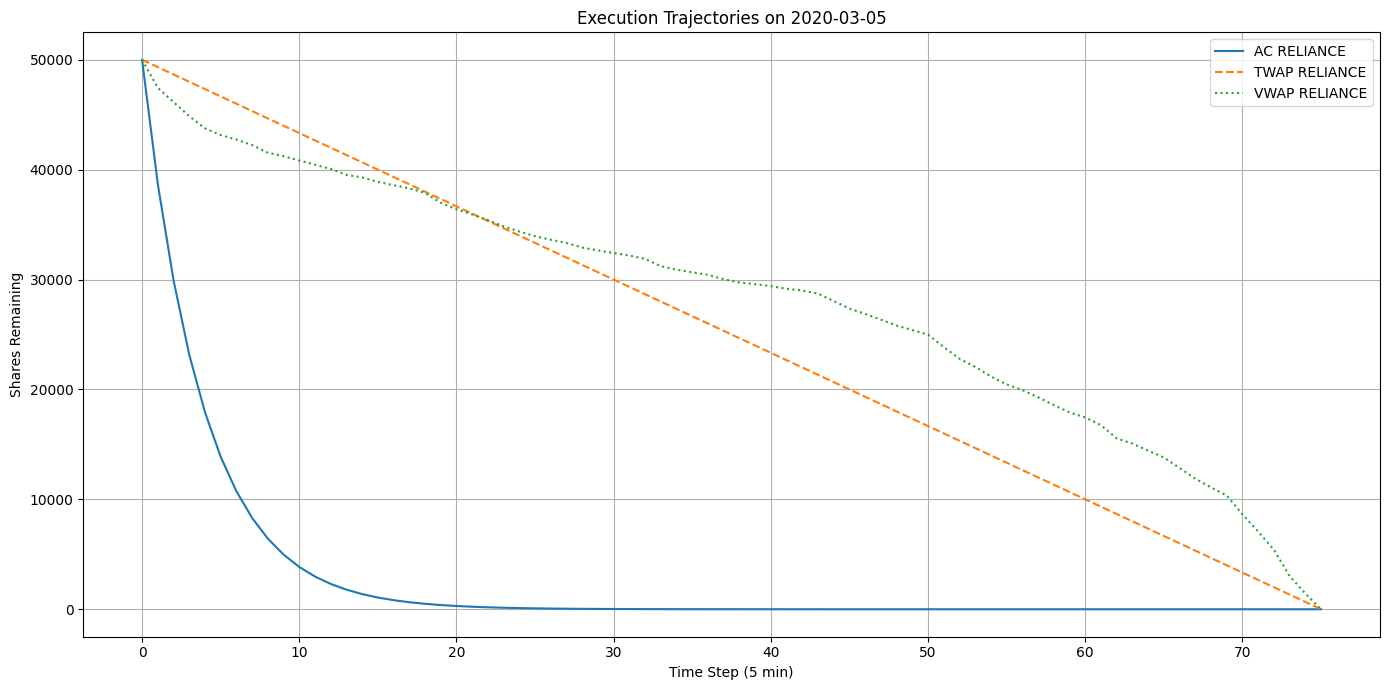

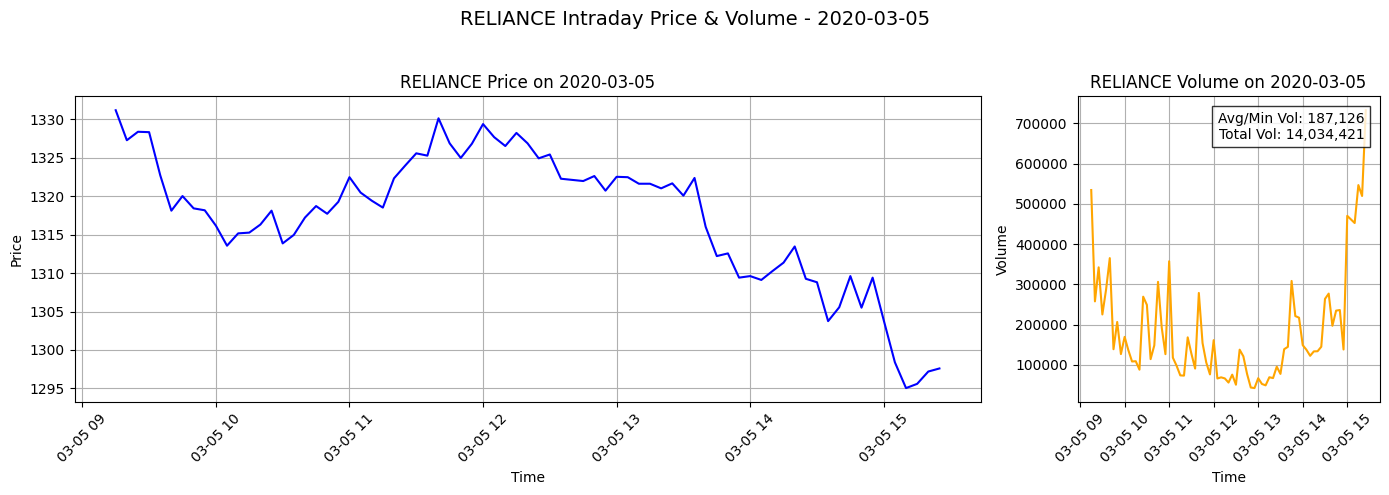

{datetime.date(2020, 3, 3): {'AC': {'expected_shortfall_bps': 220.9230213941747, 'realized_shortfall_bps': 1.853076138866604, 'execution_risk_pct': 0.26147026019226366, 'volume_weighted_price': 1332.3968575378392, 'slippage_vs_vwap_bps': 41.09476006070684}, 'TWAP': {'expected_shortfall_bps': 666.8855935816239, 'realized_shortfall_bps': -59.95821291396188, 'execution_risk_pct': 1.1075134690776247, 'volume_weighted_price': 1324.1626666666666, 'slippage_vs_vwap_bps': -20.9590419594036}, 'VWAP': {'expected_shortfall_bps': 689.6470883768246, 'realized_shortfall_bps': -39.08108115653615, 'execution_risk_pct': 1.0670124495830058, 'volume_weighted_price': 1326.9438137737322, 'slippage_vs_vwap_bps': 0.0}}, datetime.date(2020, 3, 4): {'AC': {'expected_shortfall_bps': 252.46193041252727, 'realized_shortfall_bps': -8.654332831494113, 'execution_risk_pct': 0.2572940120204628, 'volume_weighted_price': 1328.1495795367096, 'slippage_vs_vwap_bps': 57.27763841768842}, 'TWAP': {'expected_shortfall_bps': 

In [6]:
tickers = ["RELIANCE"]
X_0 = np.array([50_000])
start_date = datetime(2020, 3, 2).date()
end_date = datetime(2020, 3, 5).date()

results = run_ac_analysis(tickers, X_0, start_date, end_date, csv_mapping, lam=None, plot_overlay=True)
print(results)

FULL COVID CRASH PERFORMANCE

In [7]:
# ------------------ RUN ANALYSIS ------------------ #
all_results = {}

for ticker in list(csv_mapping.keys()):
    print("\nSTOCK:", ticker)
    ticker_name = [ticker]
    X_0 = np.array([50_000])
    start_date = datetime(2020, 2, 15).date()
    end_date = datetime(2020, 4, 15).date()

    try:
        results = run_ac_analysis(ticker_name, X_0, start_date, end_date, csv_mapping, lam=None, plot_overlay=False)
        all_results[ticker] = results
    except ValueError as e:
        print(f"⚠️ Skipping {ticker} due to error: {e}")
    except Exception as e:
        print(f"❌ Unexpected error for {ticker}: {e}")

# ------------------ INTRA-STOCK ANALYSIS ------------------ #
intra_stock_stats = {}

for ticker, result_dict in all_results.items():
    metrics = {
        'AC': {'expected': [], 'realized': [], 'risk': [], 'slippage_vs_vwap': []},
        'TWAP': {'expected': [], 'realized': [], 'risk': [], 'slippage_vs_vwap': []},
        'VWAP': {'expected': [], 'realized': [], 'risk': [], 'slippage_vs_vwap': []}
    }

    for day, res in result_dict.items():
        for strat in ['AC', 'TWAP', 'VWAP']:
            metrics[strat]['expected'].append(res[strat]['expected_shortfall_bps'])
            metrics[strat]['realized'].append(res[strat]['realized_shortfall_bps'])
            metrics[strat]['risk'].append(res[strat]['execution_risk_pct'])
            metrics[strat]['slippage_vs_vwap'].append(res[strat]['slippage_vs_vwap_bps'])

    intra_stock_stats[ticker] = {}
    for strat in ['AC', 'TWAP', 'VWAP']:
        expected = np.array(metrics[strat]['expected'])
        realized = np.array(metrics[strat]['realized'])
        risk = np.array(metrics[strat]['risk'])
        slippage = np.array(metrics[strat]['slippage_vs_vwap'])

        intra_stock_stats[ticker][strat] = {
            'mean_expected_shortfall_bps': np.mean(expected),
            'median_expected_shortfall_bps': np.median(expected),
            'RISK: std_expected_shortfall_bps': np.std(expected),

            'mean_realized_shortfall_bps': np.mean(realized),
            'median_realized_shortfall_bps': np.median(realized),
            'RISK: std_realized_shortfall_bps': np.std(realized),

            'mean_execution_risk_pct': np.mean(risk),
            'median_execution_risk_pct': np.median(risk),

            'mean_slippage_vs_vwap_bps': np.mean(slippage),
            'median_slippage_vs_vwap_bps': np.median(slippage),
            'RISK: std_slippage_vs_vwap_bps': np.std(slippage)
        }

# ------------------ INTER-STOCK ANALYSIS ------------------ #
inter_stock_stats = {}

for strat in ['AC', 'TWAP', 'VWAP']:
    mean_expected_list = []
    median_expected_list = []
    mean_realized_list = []
    median_realized_list = []
    mean_risk_list = []
    median_risk_list = []
    mean_slippage_list = []
    median_slippage_list = []

    for ticker in intra_stock_stats:
        stat = intra_stock_stats[ticker][strat]
        mean_expected_list.append(stat['mean_expected_shortfall_bps'])
        median_expected_list.append(stat['median_expected_shortfall_bps'])
        mean_realized_list.append(stat['mean_realized_shortfall_bps'])
        median_realized_list.append(stat['median_realized_shortfall_bps'])
        mean_risk_list.append(stat['mean_execution_risk_pct'])
        median_risk_list.append(stat['median_execution_risk_pct'])
        mean_slippage_list.append(stat['mean_slippage_vs_vwap_bps'])
        median_slippage_list.append(stat['median_slippage_vs_vwap_bps'])

    inter_stock_stats[strat] = {
        # Expected Shortfall
        'mean_of_mean_expected_shortfall_bps': np.mean(mean_expected_list),
        'median_of_mean_expected_shortfall_bps': np.median(mean_expected_list),
        'std_of_mean_expected_shortfall_bps': np.std(mean_expected_list),

        'mean_of_median_expected_shortfall_bps': np.mean(median_expected_list),
        'median_of_median_expected_shortfall_bps': np.median(median_expected_list),
        'std_of_median_expected_shortfall_bps': np.std(median_expected_list),

        # Realized Shortfall
        'mean_of_mean_realized_shortfall_bps': np.mean(mean_realized_list),
        'median_of_mean_realized_shortfall_bps': np.median(mean_realized_list),
        'std_of_mean_realized_shortfall_bps': np.std(mean_realized_list),

        'mean_of_median_realized_shortfall_bps': np.mean(median_realized_list),
        'median_of_median_realized_shortfall_bps': np.median(median_realized_list),
        'std_of_median_realized_shortfall_bps': np.std(median_realized_list),

        # Execution Risk
        'mean_of_mean_execution_risk_pct': np.mean(mean_risk_list),
        'median_of_mean_execution_risk_pct': np.median(mean_risk_list),

        'mean_of_median_execution_risk_pct': np.mean(median_risk_list),
        'median_of_median_execution_risk_pct': np.median(median_risk_list),

        # Slippage vs VWAP
        'mean_of_mean_slippage_vs_vwap_bps': np.mean(mean_slippage_list),
        'median_of_mean_slippage_vs_vwap_bps': np.median(mean_slippage_list),
        'std_of_mean_slippage_vs_vwap_bps': np.std(mean_slippage_list),

        'mean_of_median_slippage_vs_vwap_bps': np.mean(median_slippage_list),
        'median_of_median_slippage_vs_vwap_bps': np.median(median_slippage_list),
        'std_of_median_slippage_vs_vwap_bps': np.std(median_slippage_list)
    }

# ------------------ OPTIONAL: Display or Save ------------------ #
import pprint
pp = pprint.PrettyPrinter(indent=2)

print("\n=== Inter-Stock Statistics ===")
pp.pprint(inter_stock_stats)

# ------------------ PERFORMANCE COMPARISON: AC vs TWAP & VWAP ------------------ #
print("\n=== Performance Advantage of AC over TWAP and VWAP (in %) ===")
metrics_to_compare = list(inter_stock_stats['AC'].keys())

comparison_results = {}

for metric in metrics_to_compare:
    comparison_results[metric] = {}
    ac_value = inter_stock_stats['AC'][metric]

    for other in ['TWAP', 'VWAP']:
        other_value = inter_stock_stats[other][metric]
        improvement_pct = ((other_value - ac_value) / np.abs(other_value)) * 100
        comparison_results[metric][f'AC_vs_{other}'] = improvement_pct

pp.pprint(comparison_results)

import pandas as pd

# ------------------ Save Intra-Stock Statistics ------------------ #
intra_rows = []

for ticker, strat_data in intra_stock_stats.items():
    for strat, metrics in strat_data.items():
        row = {'ticker': ticker, 'strategy': strat}
        row.update(metrics)
        intra_rows.append(row)

intra_df = pd.DataFrame(intra_rows)
intra_df.to_csv("intra_stock_stats.csv", index=False)
print("\n📁 Saved: intra_stock_stats.csv")

# ------------------ Save Inter-Stock Statistics ------------------ #
inter_rows = []

for strat, metrics in inter_stock_stats.items():
    row = {'strategy': strat}
    row.update(metrics)
    inter_rows.append(row)

inter_df = pd.DataFrame(inter_rows)
inter_df.to_csv("inter_stock_stats.csv", index=False)
print("📁 Saved: inter_stock_stats.csv")



STOCK: INDUSINDBK

=== Running for 2020-02-18 (calibration on 2020-02-17) ===

=== IS-based Slippage and Risk ===
Best lambda: 3.3967385822722025e-15
AC Expected Shortfall:         429.9397 bps
TWAP Expected Shortfall:       1091.8616 bps
VWAP Expected Shortfall:       987.6750 bps
AC Realized Shortfall:         -148.9166 bps
TWAP Realized Shortfall:       -295.5796 bps
VWAP Realized Shortfall:       -244.3423 bps
AC Execution Risk:             0.4611%
TWAP Execution Risk:           1.8398%
VWAP Execution Risk:           1.5494%
AC Volume-Weighted Price:       1141.3958
TWAP Volume-Weighted Price:     1124.4027
VWAP Volume-Weighted Price:     1130.3393
AC Slippage vs VWAP:            97.8158 bps
TWAP Slippage vs VWAP:          -52.5206 bps
VWAP Slippage vs VWAP:          0.0000 bps

=== Running for 2020-02-19 (calibration on 2020-02-18) ===

=== IS-based Slippage and Risk ===
Best lambda: 7.107279696773412e-15
AC Expected Shortfall:         301.1803 bps
TWAP Expected Shortfall:       